In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import datasets, layers, models, losses

In [2]:
dataset_dir = "C:/Users/Hannah/OneDrive/Documents/MIDS/207/Final_Project/mids_207_final_project/"

img_height = 32
img_width = 32


# Load training and validation data
train = keras.utils.image_dataset_from_directory(
  os.path.join(dataset_dir, "train"),
  seed = 512,
  image_size = (img_height, img_width),
  batch_size = 100000)

Found 100000 files belonging to 2 classes.


In [3]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
# Load test data
test = tf.keras.utils.image_dataset_from_directory(
  dataset_dir + "test",
  seed = 512,
  image_size = (img_height, img_width), 
  batch_size = 20000)
test

Found 20000 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
classes = train.class_names
classes

['FAKE', 'REAL']

In [6]:
train_list = list(train)
train_imgs = train_list[0][0].numpy()
train_labels = train_list[0][1].numpy()
train_imgs.shape

(100000, 32, 32, 3)

In [8]:
test_list = list(test)
test_imgs = test_list[0][0].numpy()
test_labels = test_list[0][1].numpy()
test_imgs.shape

(20000, 32, 32, 3)

In [9]:
# Build model

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

keras.backend.clear_session()

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_imgs) 
test_ds = preprocess_input(test_imgs)
base_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

In [10]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(1, activation='sigmoid')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [11]:
# Compile model
model.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
history = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, verbose = 3, callbacks=[es])


Epoch 1/50


Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50


In [14]:
history = pd.DataFrame(history.history)
display(history)

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.402420,0.830912,0.843562,0.811171,0.317393,0.86395,0.881607,0.844787
1,0.292113,0.876538,0.883440,0.866623,0.308770,0.87330,0.885482,0.861177
2,0.259292,0.891913,0.896528,0.885308,0.279558,0.88320,0.884373,0.885071
3,0.234855,0.903938,0.906227,0.900431,0.272640,0.88485,0.902645,0.866015
4,0.214076,0.912775,0.915328,0.909084,0.274514,0.88760,0.874454,0.908472
5,0.198117,0.918975,0.920741,0.916307,0.275704,0.88695,0.878185,0.901856
6,0.183670,0.925175,0.926625,0.922953,0.292757,0.88555,0.886958,0.887046
7,0.171267,0.929913,0.930238,0.929048,0.304127,0.88370,0.895639,0.871939
8,0.160195,0.934788,0.935813,0.933161,0.322474,0.88150,0.912835,0.846860
9,0.150264,0.939075,0.940359,0.937199,0.313566,0.88510,0.900716,0.868878


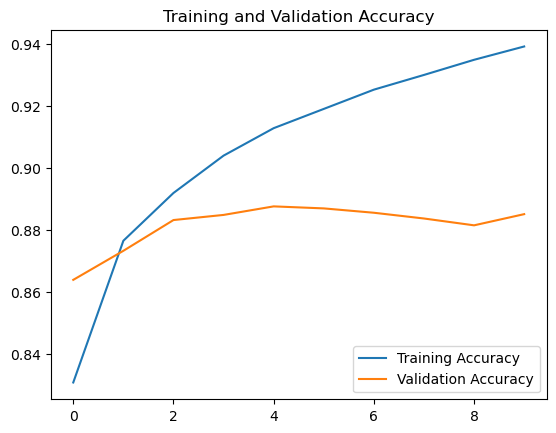

In [17]:
plt.plot(range(10), history["accuracy"], label="Training Accuracy")
plt.plot(range(10), history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

## Fine Tuning

In [ ]:
base_model.trainable = True


model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss="binary_crossentropy",
              metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")])

# Train end-to-end
history_tuned = model.fit(train_ds, train_labels, epochs=20, validation_split=0.2, batch_size=32, verbose = 3, callbacks=[es])

In [ ]:
history_tuned = pd.DataFrame(history_tuned.history)
display(history_tuned)

In [ ]:
plt.plot(range(20), history_tuned["accuracy"], label="Training Accuracy")
plt.plot(range(20), history_tuned["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

In [21]:
model.evaluate(test, return_dict=True)

1/1 [==============================] - 153s 153s/step - loss: 1.7042 - accuracy: 0.6538 - precision: 0.5946 - recall: 0.9668


{'loss': 1.7041642665863037,
 'accuracy': 0.6537500023841858,
 'precision': 0.5945513844490051,
 'recall': 0.9667999744415283}